In [61]:
from itertools import product

sim_id = 0
reserve_factor = 0.0

wind_pmax_list = list(range(50, 550, 50))

# pmax_ratio: battery_power_pmax/wind_pmax
pmax_ratio_list = [r/10 for r in range(2, 12, 2)]

# battery size in hour
battery_size = 4

n_scenario_list = [3, 5, 8, 10]
participation_modes = ["Bid", "SelfSchedule"]

spec_comb_product = product(wind_pmax_list, pmax_ratio_list, n_scenario_list, participation_modes)

count = 0
for wind_pmax, p_max_ratio, n_scenario, pm in spec_comb_product:

    battery_pmax = wind_pmax * p_max_ratio
    battery_energy_capacity = battery_pmax * battery_size
    count += 1
print(count)

400


In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tslearn.utils import to_time_series_dataset
import re

In [57]:
# choose 113_PV_1 and 122_WIND_1


class WINDPV:
    def __init__(self, dispatch_data, LMP_data, wind_data, pv_data, metric, years, wind_gen, pv_gen):
        '''
        Initializes the bidder object.

        Arguments:
            dispatch_data: csv files with the dispatch power data

            wind_data: csv files with wind profile

            pv_data: csv files with pv profile

            metric: distance metric (“euclidean” or “dtw”).

            years: The size for the clustering dataset.

            wind_gen: name of wind generator

            pv_gen: name of pv generator

        Return:
            None
        '''
        self.dispatch_data = dispatch_data
        self.LMP_data = LMP_data
        self.wind_data = wind_data
        self.pv_data = pv_data
        self.metric = metric
        self.years = int(years)
        self.wind_gen = wind_gen
        self.pv_gen = pv_gen

        # make a dict key = generator name, value = pmax
        _wind_gen_pmax = {}
        _wind_gen_name = ['309_WIND_1', '317_WIND_1', '303_WIND_1', '122_WIND_1']
        _win_gen_pmax_list = [148.3, 799.1, 847, 713.5]
        _pv_gen_pmax = {}
        _pv_gen_name = ['320_PV_1', '314_PV_1', '314_PV_2', '313_PV_1', '314_PV_3', '314_PV_4', '313_PV_2',\
                       '310_PV_1', '324_PV_1', '312_PV_1', '310_PV_2', '324_PV_2', '324_PV_3', '113_PV_1',\
                       '319_PV_1', '215_PV_1', '102_PV_1', '101_PV_1', '102_PV_2', '104_PV_1', '101_PV_2',\
                       '101_PV_3', '101_PV_4', '103_PV_1', '119_PV_1']
        _pv_gen_pmax_list = [51.6, 51.6, 51.6, 95.1, 92.7, 51.6, 93.3,\
                            51.7, 49.7, 94.1, 51.6, 51.6, 51, 93.6,\
                            188.2, 125.1, 25.6, 25.9, 25.3, 26.8, 26.7,\
                            26.2, 25.8, 61.5, 66.6]

        for name, pmax in zip(_wind_gen_name, _win_gen_pmax_list):
            _wind_gen_pmax[name] = pmax

        for name, pmax in zip(_pv_gen_name, _pv_gen_pmax_list):
            _pv_gen_pmax[name] = pmax

            
        # check the wind generator and pv generator name are correct.
        # Assign pmax accroding to generators.
        if self.wind_gen in _wind_gen_name:
            self.wind_gen_pmax = _wind_gen_pmax[self.wind_gen]
        else:
            raise NameError("wind generator name {} is invaild.".format(self.wind_gen))

        if self.pv_gen in _pv_gen_name:
            self.pv_gen_pmax = _pv_gen_pmax[self.pv_gen]
        else:
            raise NameError("PV generator name {} is invaild.".format(self.wind_gen))       

    def read_input_pmax(self):

        '''
        read the input p_max for each simulation year

        Arguments:
            None

        Return:
            None
        '''

        input_data = 'prescient_generator_inputs.h5'
        df_input_data = pd.read_hdf(input_data)

        # first column is the p_max, from run_0 to run_64799
        df_pmax = df_input_data.iloc[:,1]
        pmax = df_pmax.to_numpy(dtype = float)
        self.pmax = pmax
        
        return
            
    def read_data(self):

        '''
        read clustering data from dispatch csv files
        
        Aruguments:
            None

        Return: 
            numpy array with dispatch data.
        '''

        ### to save time, need to modify to code to only read the target lines 
        df_dispatch = pd.read_csv(self.dispatch_data, nrows = self.years)
        df_LMP = pd.read_csv(self.LMP_data, nrows = self.years)

        # drop the first column
        df_dispatch_data = df_dispatch.iloc[: , 1:]
        df_LMP_data = df_LMP.iloc[: , 1:]

        # the first column is the run_index. Put them in an array
        df_index = df_dispatch.iloc[:,0]
        run_index = df_index.to_numpy(dtype = str)

        # In csv files, every run is not in sequence from 0 to 64999. 
        # run indexs are strings of 'run_xxxx.csv', make xxxx into a list of int
        self.index = []
        for run in run_index:
            index_num = re.split('_|\.',run)[1]
            self.index.append(int(index_num))

        # transfer the data to the np.array, dimension of test_years*8736(total hours in one simulation year)
        dispatch_array = df_dispatch_data.to_numpy(dtype = float)
        LMP_array = df_LMP_data.to_numpy(dtype = float)
        
        return dispatch_array, LMP_array

    def read_wind_pv_data(self):

        '''
        length of wind and pv data is 366*24 = 8784 (366 days including Feb 29)
        length of dispatch data is 364*24 = 8736 (364 days, without Jan 1 and Dec 31)
        exclude first and last 24 time points in wind and pv data.
        '''
        wind_file = self.wind_data
        pv_file = self.pv_data

        total_wind_profile = pd.read_csv(wind_file)
        total_pv_profile = pd.read_csv(pv_file)
        selected_wind_data = total_wind_profile[self.wind_gen].to_numpy()
        selected_pv_data = total_pv_profile[self.pv_gen].to_numpy()

        # exclude Jan 1 and Dec 31
        # scale data by pmax to get capacity factors
        selected_wind_data = selected_wind_data[24:8760]/self.wind_gen_pmax
        selected_pv_data = selected_pv_data[24:8760]/self.pv_gen_pmax
        
#         joint_wind_pv = []
#         time_len = 24
#         day_num = int(len(selected_wind_data)/time_len)
#         for i in range(day_num):
#             joint_wind_pv.append([selected_wind_data[i*24:(i+1)*24], selected_pv_data[i*24:(i+1)*24]])
#         # print(np.shape(joint_wind_pv))
        return selected_wind_data, selected_pv_data


    def dispatch_visualize(self, dispatch_array, selected_wind_data):
        for idx, data in zip(self.index, dispatch_array):
            cf_year = data/self.pmax[idx]
            f,ax1 = plt.subplots(figsize = ((6,6)))
#             print(len(cf_year))
            ax1.scatter(selected_wind_data, cf_year)
            ax1.set_xlabel('122_wind_1 capacify factor')
            ax1.set_ylabel('123_steam_3 capacify factor')
        return
    
    def LMP_visualize(self, LMP_array, selected_wind_data, year_idx = 0):
        selected_year = LMP_array[year_idx]
        for i, j in enumerate(selected_year):
            if j >= 200:
                selected_year[i] = 200
        
        for i in range(12):
            f,ax1 = plt.subplots(figsize = ((6,6)))
            ax1.scatter(selected_wind_data[i*30:(i+1)*30], selected_year[i*30:(i+1)*30])
            ax1.set_xlabel('122_wind_1 capacify factor')
            ax1.set_ylabel('LMP/$/MW')
        return

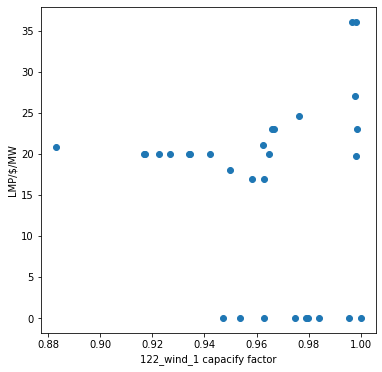

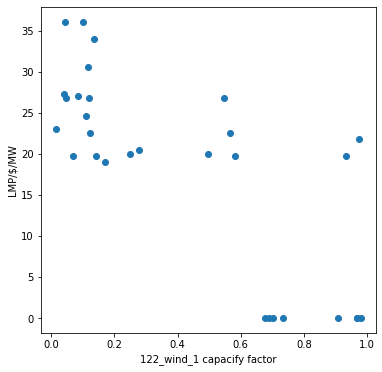

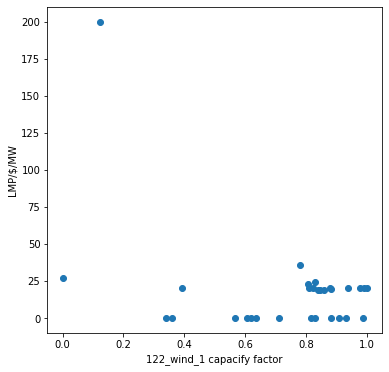

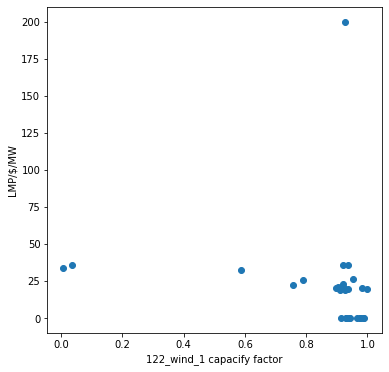

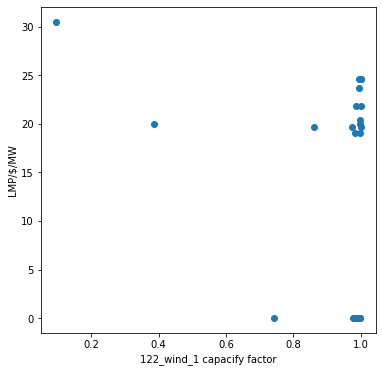

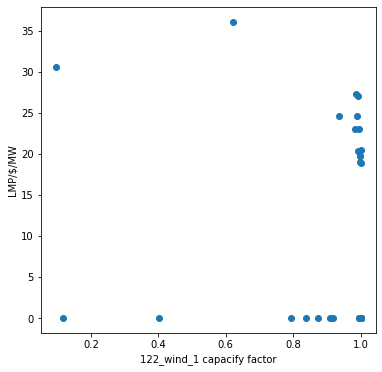

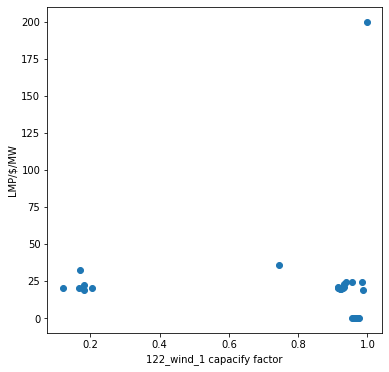

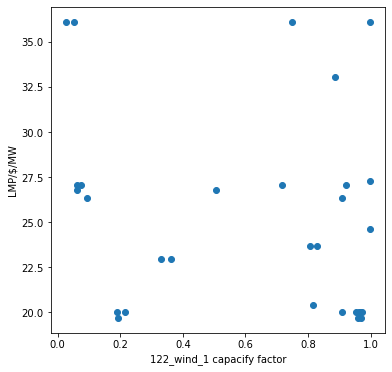

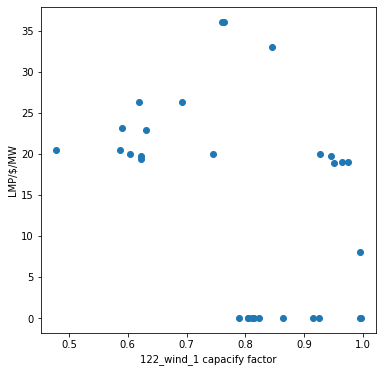

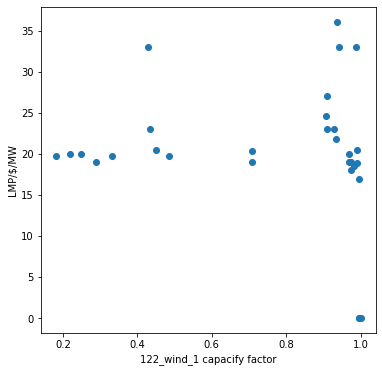

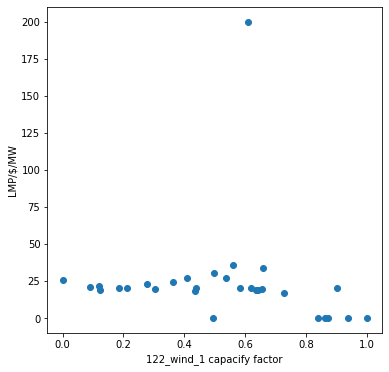

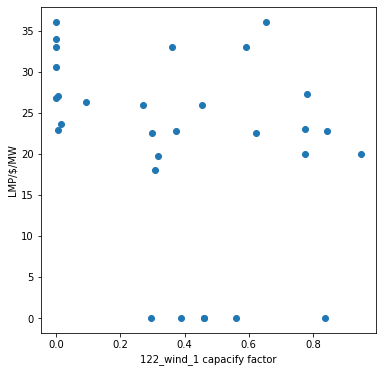

In [58]:
dispatch_data = 'Dispatch_shuffled_data_0.csv'
wind_data = 'DAY_AHEAD_wind.csv'
LMP_data = 'LMP_shuffled_data_0.csv'
pv_data =  'DAY_AHEAD_pv.csv'
metric = 'euclidean'
years = 10
pv_gen = '113_PV_1'
wind_gen = '122_WIND_1'

task = WINDPV(dispatch_data, LMP_data, wind_data, pv_data, metric, years, wind_gen, pv_gen)
task.read_input_pmax()
dispatch_data, LMP_data = task.read_data()
wind_data, pv_data = task.read_wind_pv_data()
# task.dispatch_visualize(dispatch_data, wind_data)
task.LMP_visualize(LMP_data, wind_data)
# LMP_data[0][:720]

In [40]:
task.index

[54242, 5707, 33622, 44247, 50261, 31734, 24288, 12896, 57587, 24855]